# Text Vectorization and Machine Learning Modelling

In the first part, we had covered the basic EDA along with the Feature Engineering. In this part, we will try to convert the text data into some form of vectors. We will be using TFIDF weighted Word2Vec based vectorization. 

After that, we will go on to build Machine Learning Models to classify the given pair of questions as Duplicates or Non-Duplicates.

# Preliminary Steps

## Importing Libraries and Packages

In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

## Loading the Data

In [8]:
x_train=pd.read_csv("training.csv").dropna()
x_test=pd.read_csv("testing.csv").dropna()

y_train=x_train.pop('is_duplicate')
y_test=x_test.pop('is_duplicate')

In [9]:
#printing the shapes of train and test set
print("Shape of x_train =", x_train.shape)
print("Shape of x_test =", x_test.shape)
print("Shape of y_train =", y_train.shape)
print("Shpae of y_test =", y_test.shape)

Shape of x_train = (282862, 31)
Shape of x_test = (121227, 31)
Shape of y_train = (282862,)
Shpae of y_test = (121227,)


# Text Vectorization

## Training the custom word2vec model based on our corpus

In [4]:
questions=x_train['question1'].append(x_train['question2']).values.astype('str')

#converting the strings to lists
list_of_questions=[ele.split() for ele in questions]
print("Some of the questions are:")
list_of_questions[:4]

Some of the questions are:


[['best', 'way', 'gain', 'weight', 'healthi', 'way'],
 ['add', 'someon', 'group', 'viber', 'know'],
 ['hold', 'tablet', 'horizont', 'vertic'],
 ['best', 'roller', 'skate', 'brand']]

In [8]:
#training the custom w2v model
w2v_model=Word2Vec(list_of_questions, size=300,
                   min_count=1, window=5, workers=8)

## Finding TFIDF Vectorizations for questions

In [9]:
#finding TFIDF vectorizations for question 1
tfidf_q1 = TfidfVectorizer()
tfidf_q1.fit(x_train.question1)
words_q1 = tfidf_q1.get_feature_names()
#transforming the sentences into vectors
question1_train_tfidf = tfidf_q1.transform(x_train.question1)
question1_test_tfidf = tfidf_q1.transform(x_test.question1)

#finding TFIDF vectorizations for question 2
tfidf_q2 = TfidfVectorizer()
tfidf_q2.fit(x_train.question2)
words_q2 = tfidf_q2.get_feature_names()
#transforming the sentences into vectors
question2_train_tfidf = tfidf_q2.transform(x_train.question2)
question2_test_tfidf = tfidf_q2.transform(x_test.question2)

## Generating TFIDF weighted Word2Vec vectorizations

In [16]:
#getting the TFIDF-W2V embeddings
def w2v_tfidf(q, tfidf_q, words_q_tfidf, w2v_model):
    w2v_vector=[]
    row=0
    #iterating through all the questions
    for qu in tqdm(q):
        vec = np.zeros(300)
        tfidf_sum = 0
        #iterating through each word in question
        for w in qu.split(" "):
            if w in w2v_model.wv.vocab and w in words_q_tfidf:
                vec_w = w2v_model.wv[w]
                tfidf = tfidf_q[row, words_q_tfidf.index(w)]
                tfidf_sum += tfidf
                vec_w = vec_w*tfidf
                vec = vec + vec_w
        if tfidf_sum > 0:
            vec = vec/tfidf_sum
        w2v_vector.append(vec)
        row += 1
        
    return w2v_vector    

In [17]:
#vectorizing the question1 from train and test
tfidf_w2v_question1_train = w2v_tfidf(x_train.question1, question1_train_tfidf,
                                      words_q1, w2v_model)
tfidf_w2v_question1_test = w2v_tfidf(x_test.question1, question1_test_tfidf,
                                     words_q1, w2v_model)
#vectorizing the question2 from train and test
tfidf_w2v_question2_train = w2v_tfidf(x_train.question2, question2_train_tfidf,
                                      words_q2, w2v_model)
tfidf_w2v_question2_test = w2v_tfidf(x_test.question2, question2_test_tfidf,
                                     words_q2, w2v_model)

100%|██████████| 121227/121227 [10:52<00:00, 185.71it/s]


# Final datasets:

In [38]:
x_tr = x_train.iloc[:,5:]
x_tr[["q1_w"+str(i) for i in range(1,301)]] = np.array(tfidf_w2v_question1_train)
x_tr[["q2_w"+str(i) for i in range(1,301)]] = np.array(tfidf_w2v_question2_train)

x_te = x_test.iloc[:,5:]
x_te[["q1_w"+str(i) for i in range(1,301)]] = np.array(tfidf_w2v_question1_test)
x_te[["q2_w"+str(i) for i in range(1,301)]] = np.array(tfidf_w2v_question2_test)

In [39]:
#saving to pickle files
with open('training_data.pkl','wb') as f:
    pickle.dump(x_tr,f)
with open('testing_data.pkl','wb') as f:
    pickle.dump(x_te,f)

In [10]:
#saving to pickle files
with open('training_data.pkl','rb') as f:
    x_tr = pickle.load(f)
with open('testing_data.pkl','rb') as f:
    x_te = pickle.load(f)

In [11]:
print(f"Final shape of x_train = {x_tr.shape}")
print(f"Final shape of x_test = {x_te.shape}")
print(f"\nFinal shape of y_train = {y_train.shape}")
print(f"Final shape of y_test = {y_test.shape}")

Final shape of x_train = (282862, 626)
Final shape of x_test = (121227, 626)

Final shape of y_train = (282862,)
Final shape of y_test = (121227,)


Checking if the distribution of classes is similar among the 2 sets or not.

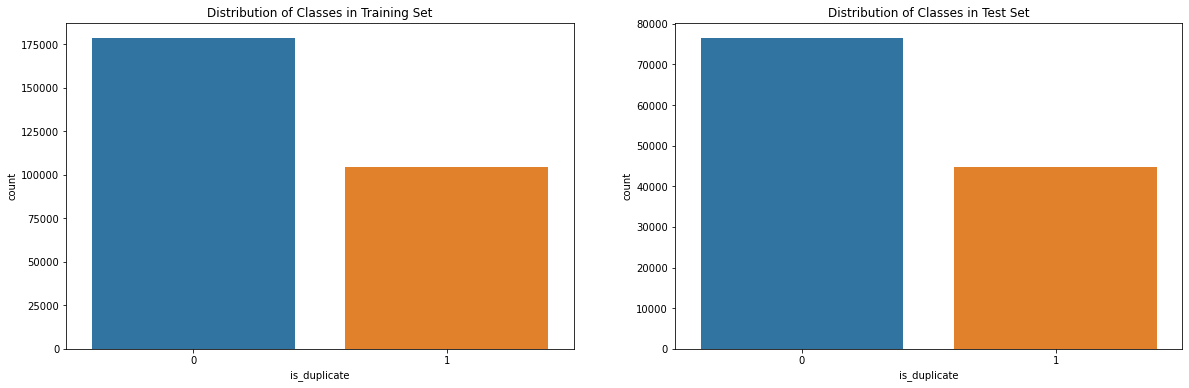

In [41]:
plt.figure(figsize = (20,6))

plt.subplot(1,2,1)
plt.title("Distribution of Classes in Training Set")
sns.countplot(y_train)

plt.subplot(1,2,2)
plt.title("Distribution of Classes in Test Set")
sns.countplot(y_test)

plt.show()

Thus, we notice that both the sets have same distribution of classes among them.

In [7]:
#standardizing the data
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr.values)
x_te = scaler.transform(x_te.values)

# Modelling

In [12]:
def plot_cnf_matrix(y_true,y_pred):
    '''
    Function to plot the Confusion Matrix, Precision Matrix and Recall Matrix
    '''
    
    cnf=confusion_matrix(y_true,y_pred)
    
    labels=[0,1]
    plt.figure(figsize=(25,8))
    sns.set(font_scale=2)
    plt.subplot(1,3,1)
    sns.heatmap(cnf,annot=True,fmt='g',cmap='Blues',annot_kws={'size':15},xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    rec=(cnf.T/cnf.sum(axis=1)).T
    
    pre=cnf/cnf.sum(axis=0)
    
    plt.subplot(1,3,2)
    sns.heatmap(pre,annot=True,fmt='g',cmap='Blues',annot_kws={'size':15},xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Precision Matrix")
    
    plt.subplot(1,3,3)
    sns.heatmap(rec,annot=True,fmt='g',cmap='Blues',annot_kws={'size':15},xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Recall Matrix")

## Building a random model

We first create a random model, to generate the baseline scores, which will be used to compare the ML models with. 
We require baseline score, especially for log-loss, because log-loss lies between 0 to infinity, and thus need a value to compare our ML model with. If the ML model gets a log-loss worse than the random model, it means the ML model isn't performing in a sane manner.

In [44]:
#generating the predicted probabilities and class labels for test set
y_pred_proba_test = np.random.uniform(0,1, x_test.shape[0])
y_pred_test = np.round(y_pred_proba_test)

Confusion Matrix for Test Dataset


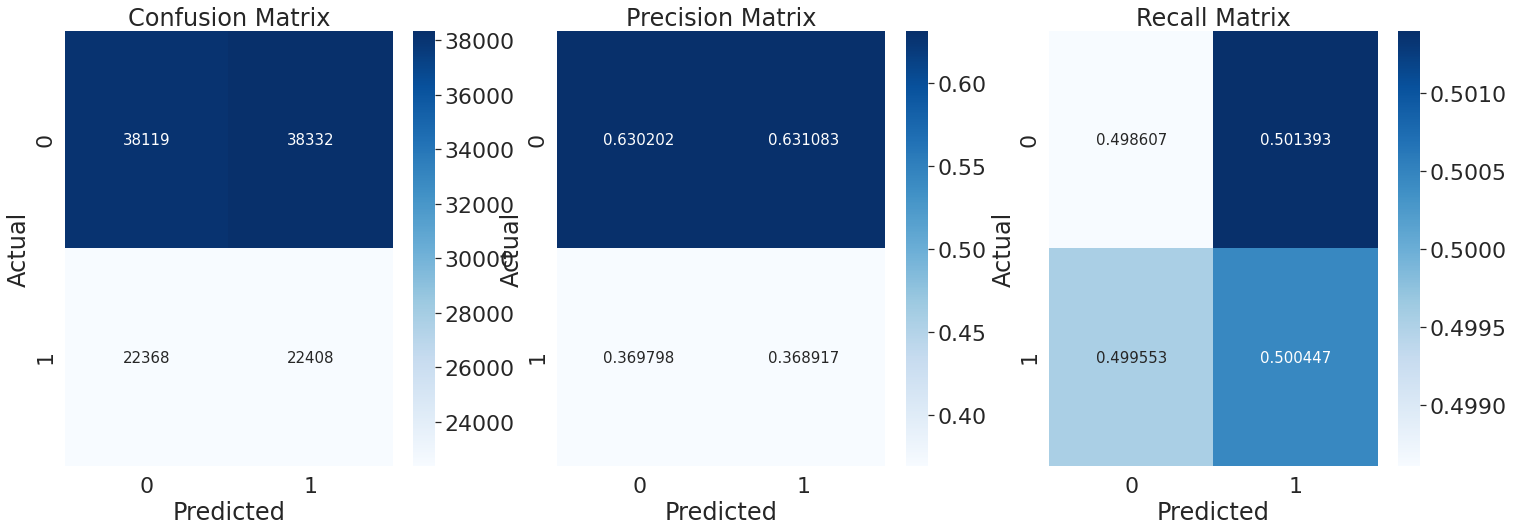

In [45]:
print("Confusion Matrix for Test Dataset")
plot_cnf_matrix(y_test, y_pred_test)

In [46]:
print("Log loss for random model is: ", log_loss(y_test,y_pred_proba_test))

Log loss for random model is:  0.9999421069076613


## Logistic Regression

### Hyper-param tuning and training

Doing GridSearchCV for finding the optimal hyperparameter alpha.

In [47]:
param = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

cv_loss = []
train_loss = []
for ele in param['alpha']:

    clf = SGDClassifier(loss='log',
                        penalty='l2',
                        alpha=ele,
                        class_weight='balanced', n_jobs = -1)

    cal = CalibratedClassifierCV(clf, method='sigmoid', cv=3)

    scores = cross_val_score(cal,
                             x_tr,
                             y_train,
                             scoring='neg_log_loss',
                             cv=3,
                             n_jobs=-1)

    print("The log loss with alpha={} is = {}".format(ele, -np.mean(scores)))
    cv_loss.append(-np.mean(scores))
    cal.fit(x_tr, y_train)
    train_loss.append(log_loss(y_train, cal.predict_proba(x_tr)))

The log loss with alpha=0.0001 is = 0.42068484250434995
The log loss with alpha=0.001 is = 0.4114055659338846
The log loss with alpha=0.01 is = 0.4201960032211189
The log loss with alpha=0.1 is = 0.44848273893850005
The log loss with alpha=1 is = 0.48241487169118447
The log loss with alpha=10 is = 0.5122642324744492
The log loss with alpha=100 is = 0.5331330390855994


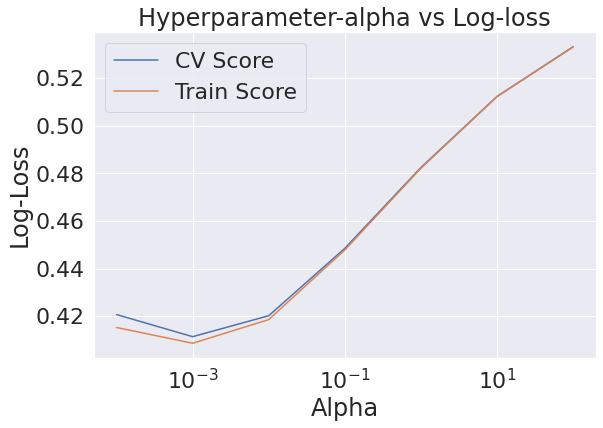

In [48]:
plt.figure(figsize=(9,6))
plt.title('Hyperparameter-alpha vs Log-loss')
plt.plot(param['alpha'],cv_loss,label='CV Score')
plt.plot(param['alpha'],train_loss,label='Train Score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Log-Loss')
plt.legend()
plt.show()

### Training wtih best alpha

From the above figure, we notice that the best alpha value with least CV log-loss is 10e-3.

In [49]:
clf=SGDClassifier(loss='log',penalty='l2',alpha=0.001,class_weight='balanced')
cal=CalibratedClassifierCV(clf,method='sigmoid',cv=5)
cal.fit(x_tr,y_train)
print("The log loss on x_test is: {}".format(log_loss(y_test,cal.predict_proba(x_te))))

The log loss on x_test is: 0.5176614596920359


Since the log-loss comes out to be lesser than a random model, we can say that the LogisticRegression model is performing sensibly.

### Inference

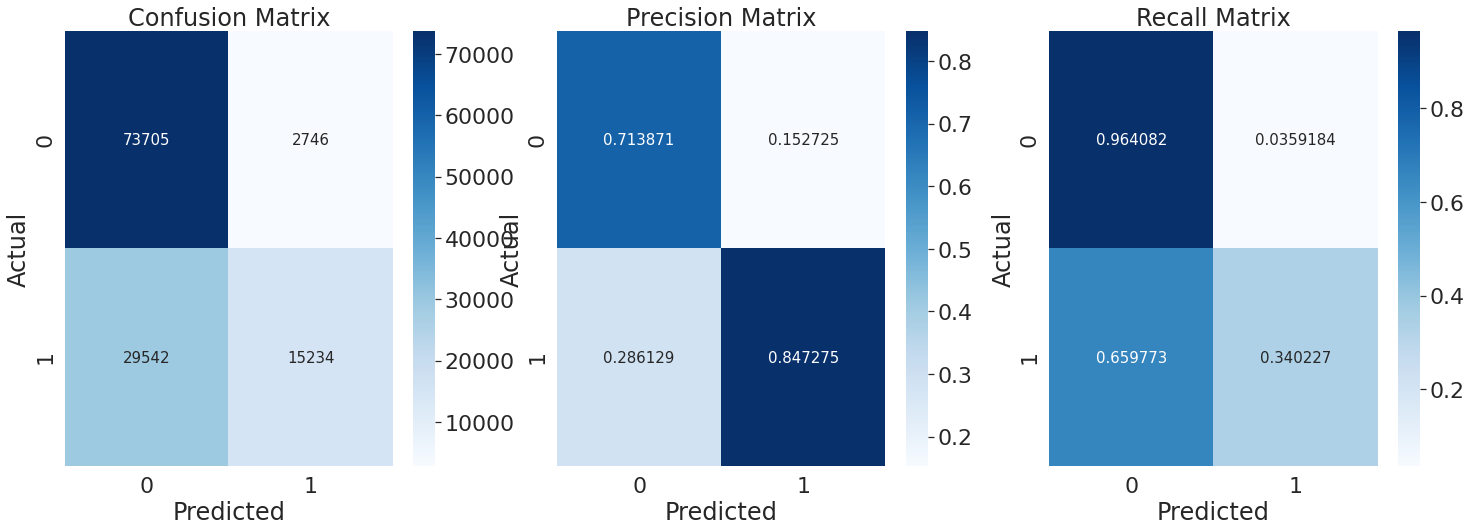

In [50]:
plot_cnf_matrix(y_test,cal.predict(x_te))

The model has good precision for both classes, however, the Recall for positive class is pretty low. This is attributed to the high number of False Negatives.

## Linear SVM

### Hyperparameter Tuning

Again, doing a GridSearchCV for finding the optimal value of hyperparameter alpha.

In [52]:
param={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

cv_loss=[]
train_loss=[]
for ele in param['alpha']:
    
    clf=SGDClassifier(loss='hinge',penalty='l1',alpha=ele,class_weight='balanced', n_jobs = -1)
    
    cal=CalibratedClassifierCV(clf,method='sigmoid',cv=3)
    
    scores=cross_val_score(cal,
                           x_tr,
                           y_train,
                           scoring='neg_log_loss',
                           cv=3,
                           n_jobs=-1)
    
    print("The log loss with alpha={} is = {}".format(ele,-np.mean(scores)))
    cv_loss.append(-np.mean(scores))
    cal.fit(x_tr,y_train)
    train_loss.append(log_loss(y_train,cal.predict_proba(x_tr)))

The log loss with alpha=1e-05 is = 0.44077191867835236
The log loss with alpha=0.0001 is = 0.4182625881652872
The log loss with alpha=0.001 is = 0.41968296658171694
The log loss with alpha=0.01 is = 0.4277298552845636
The log loss with alpha=0.1 is = 0.5009692036277292
The log loss with alpha=1 is = 0.6586086825403611
The log loss with alpha=10 is = 0.6586086825403673
The log loss with alpha=100 is = 0.6586086825403671
The log loss with alpha=1000 is = 0.6586086825403671


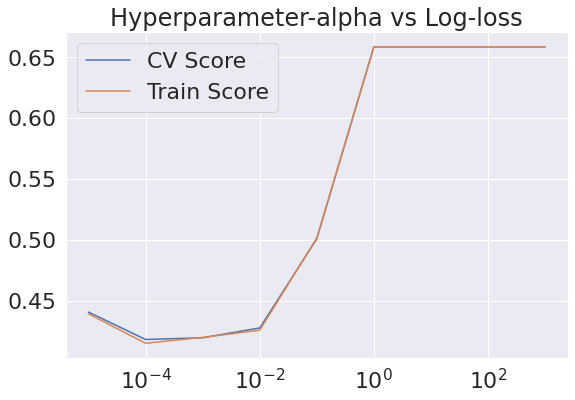

In [53]:
plt.figure(figsize=(9,6))
plt.title('Hyperparameter-alpha vs Log-loss')
plt.plot(param['alpha'],cv_loss,label='CV Score')
plt.plot(param['alpha'],train_loss,label='Train Score')
plt.xscale('log')
plt.legend()
plt.show()

From the above figure, we find that the best alpha with minimum CV and Train Log-loss comes out to be 1e-4.

### Training on best params

In [54]:
clf=SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001,class_weight='balanced')
cal=CalibratedClassifierCV(clf,method='sigmoid',cv=5)
cal.fit(x_tr,y_train)
print("The log loss on x_test is: {}".format(log_loss(y_test,cal.predict_proba(x_te))))

The log loss on x_test is: 0.5250044409085702


### Inference

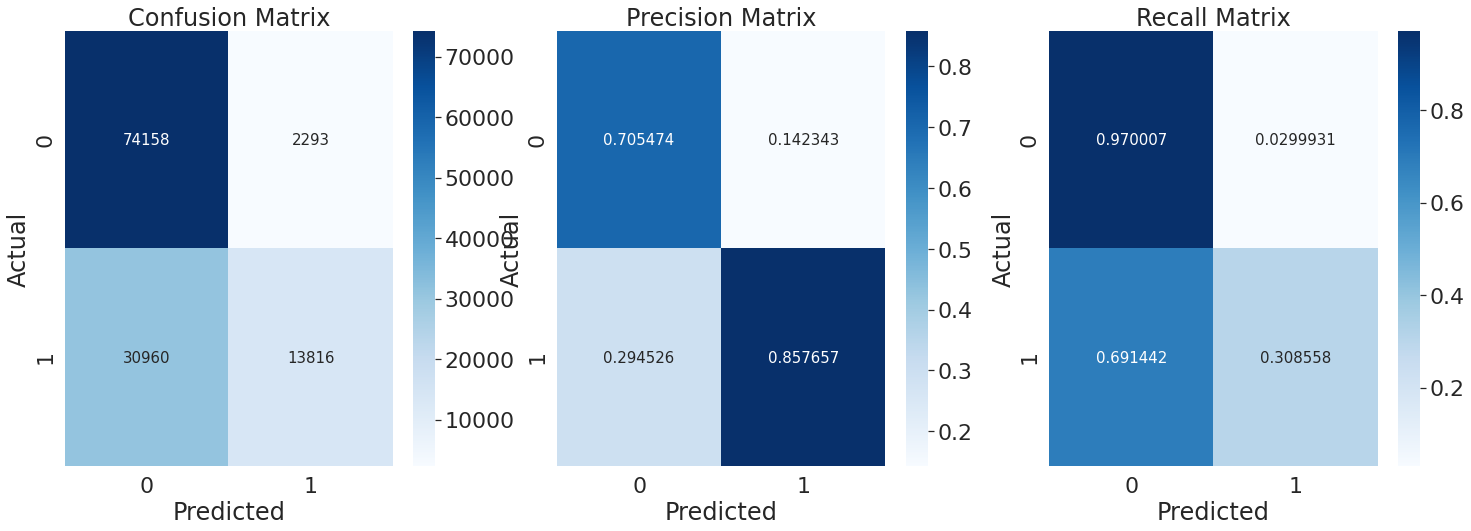

In [55]:
plot_cnf_matrix(y_test,cal.predict(x_te))

The performance of Linear SVM is very similar to Logistic Regression, as expected. However, the Recall for Positive Class has degraded even further. The test log-los is also lower than that for Logistic Regression.

## Multinomial Naive Bayes

### Hyperparameter Tuning

Again, we will do a GridSearchCV for finding the right value of hyperparameter alpha. Since MultinomialNB cannot accept negative values, we will normalize our train and test data.

In [34]:
#Normalizing the values between 0 and 1, since Multinomial Naive Bayes does not accept negative values
minmax = MinMaxScaler()
x_tr_minmax = minmax.fit_transform(x_tr)
x_te_minmax = minmax.transform(x_te)
param_grid={'base_estimator__alpha':[1e-2, 0.1, 1, 100, 1000]}
clf=MultinomialNB()
cal=CalibratedClassifierCV(clf,method='isotonic',cv=5)
model=GridSearchCV(cal, param_grid=param_grid,
                   cv=5, verbose=2,
                   return_train_score=True,
                   scoring='neg_log_loss',
                   n_jobs=2)
model.fit(x_tr_minmax,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=CalibratedClassifierCV(base_estimator=MultinomialNB(),
                                              cv=5, method='isotonic'),
             n_jobs=2,
             param_grid={'base_estimator__alpha': [0.01, 0.1, 1, 100, 1000]},
             return_train_score=True, scoring='neg_log_loss', verbose=2)

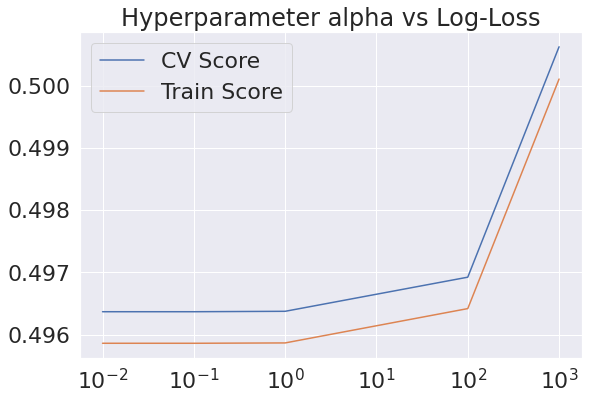

In [41]:
plt.figure(figsize=(9,6))
plt.title("Hyperparameter alpha vs Log-Loss")
plt.plot(results.param_base_estimator__alpha,results.mean_test_score,label='CV Score')
plt.plot(results.param_base_estimator__alpha,results.mean_train_score,label='Train Score')
plt.xscale('log')
plt.legend()
plt.show()

### Training on best parameters

From the Tuning, we found that the best value of alpha which gives minimum train and CV log-loss is 0.1.

In [39]:
clf = model.best_estimator_
cal=CalibratedClassifierCV(clf, method='isotonic', cv=5)
cal.fit(x_tr_minmax,y_train)
print("The log loss on x_test is: {}".format(log_loss(y_test,cal.predict_proba(x_te_minmax))))

The log loss on x_test is: 0.4976804453930295


### Inference

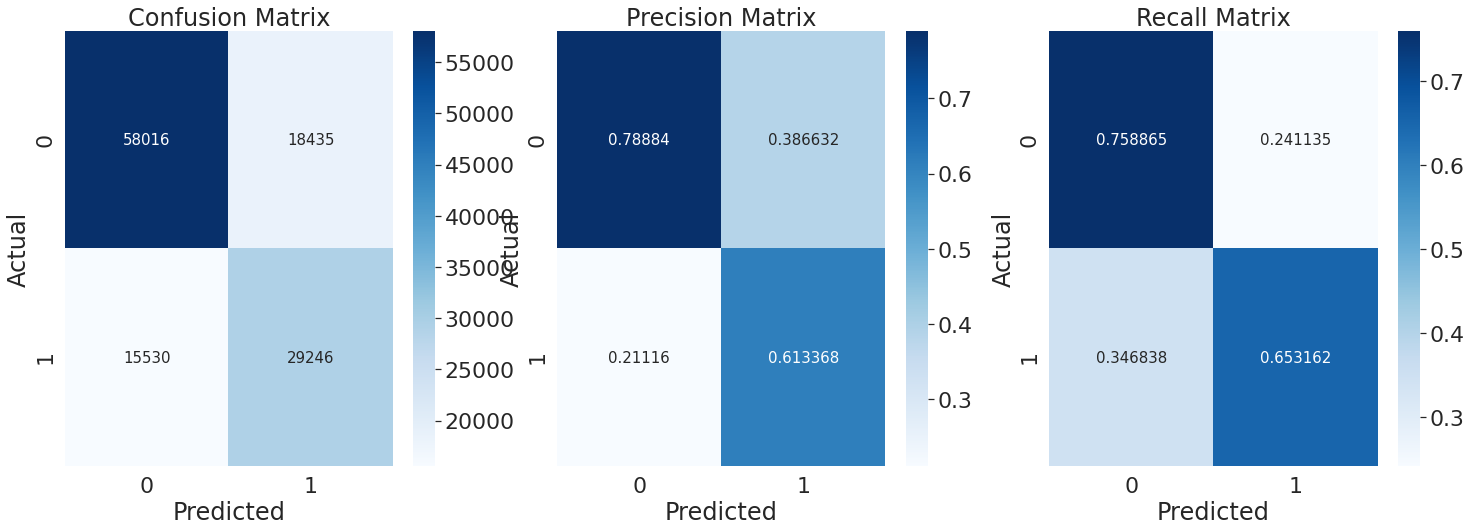

In [40]:
plot_cnf_matrix(y_test, cal.predict(x_te_minmax))

We notice that the Multinomial Naive Bayes gives better results that the Linear Classifiers, i.e. LogisticRegression and Linear SVM. This can be attributed to the fact about how well it works with text data. The Recall for positive classes is also quite better, however, for negative classes, it is not as good.

## Random Forest

### Hyper Parameter Tuning

We will be doing a RandomizedSearchCV on two parameters of the RandomForest, i.e. the n_estimators and the max_depth.

In [7]:
param_grid = {'n_estimators': list(range(200,1000)), 
             'max_depth' : list(range(10,25))}

clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)
model = RandomizedSearchCV(clf,
                           param_distributions = param_grid,
                           cv=3, verbose=3, n_iter = 10,
                           return_train_score = True,
                           scoring = 'neg_log_loss')
model.fit(x_tr, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=211, max_depth=10 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=211, max_depth=10, score=(train=-0.416, test=-0.436), total= 2.7min
[CV] n_estimators=211, max_depth=10 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV]  n_estimators=211, max_depth=10, score=(train=-0.416, test=-0.435), total= 2.6min
[CV] n_estimators=211, max_depth=10 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s


[CV]  n_estimators=211, max_depth=10, score=(train=-0.416, test=-0.436), total= 2.6min
[CV] n_estimators=930, max_depth=20 ..................................
[CV]  n_estimators=930, max_depth=20, score=(train=-0.190, test=-0.370), total=19.2min
[CV] n_estimators=930, max_depth=20 ..................................
[CV]  n_estimators=930, max_depth=20, score=(train=-0.191, test=-0.369), total=19.0min
[CV] n_estimators=930, max_depth=20 ..................................
[CV]  n_estimators=930, max_depth=20, score=(train=-0.190, test=-0.369), total=19.2min
[CV] n_estimators=965, max_depth=15 ..................................
[CV]  n_estimators=965, max_depth=15, score=(train=-0.298, test=-0.391), total=16.4min
[CV] n_estimators=965, max_depth=15 ..................................
[CV]  n_estimators=965, max_depth=15, score=(train=-0.300, test=-0.392), total=16.5min
[CV] n_estimators=965, max_depth=15 ..................................
[CV]  n_estimators=965, max_depth=15, score=(train=-

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 329.6min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1),
                   param_distributions={'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'n_estimators': [200, 201, 202, 203,
                                                         204, 205, 206, 207,
                                                         208, 209, 210, 211,
                                                         212, 213, 214, 215,
                                                         216, 217, 218, 219,
                                                         220, 221, 222, 223,
                                                         224, 225, 226, 227,
                                                         228, 229, ...]}

In [16]:
#checking the best hyperparameters obtained
model.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=24, n_estimators=570,
                       n_jobs=-1)

In [8]:
clf=RandomForestClassifier(class_weight='balanced',n_jobs=-1,n_estimators=570, max_depth = 24)
cal=CalibratedClassifierCV(clf,method='isotonic',cv=3)
cal.fit(x_tr,y_train)
print("The log loss on x_test is: {}".format(log_loss(y_test,cal.predict_proba(x_te))))

The log loss on x_test is: 0.36005836747884595


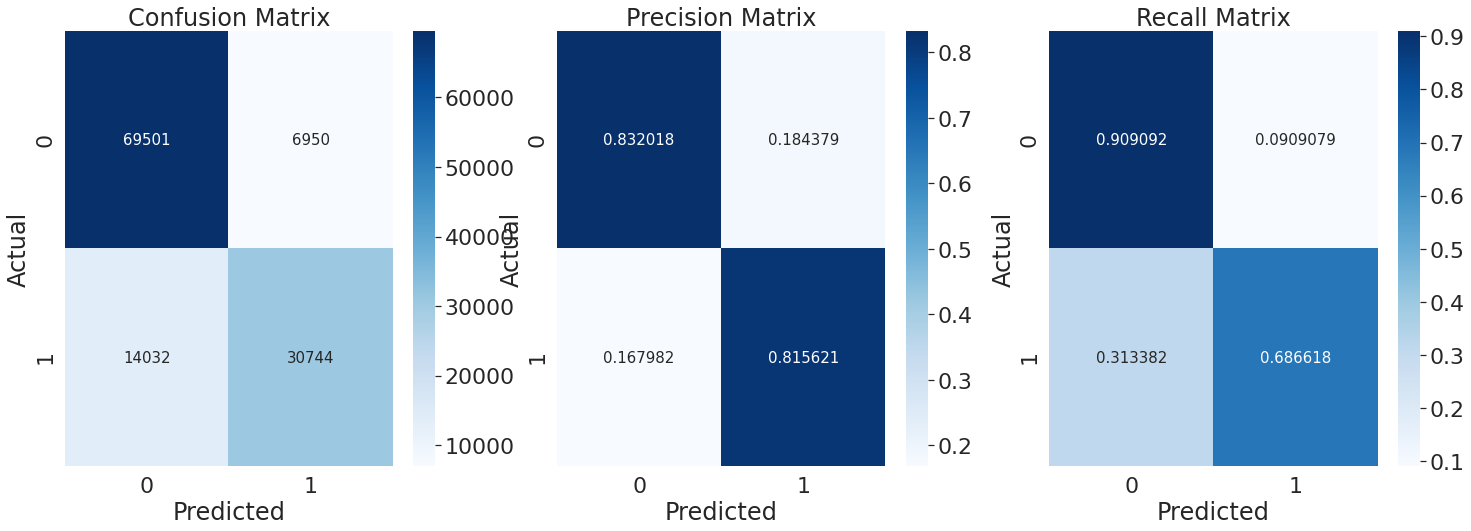

In [9]:
plot_cnf_matrix(y_test,cal.predict(x_te))

We notice that the performance of model has improved significantly as compared to the other models. The Recall value is the highest so far for the positive class. The Precision values are also sensible enough. The log-loss is also very less, lowest so far.

## LGBM

### Hyperparameter Tuning

For this model, since there are too many number of tunable hyperparameters, we will use BayesianOptimization for finding the best set of hyperparameters along with Stratified K-Fold CV.

In [16]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV log-loss
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 266
    }
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    
    cv_preds = np.zeros(x_tr.shape[0])
    for train_indices, cv_indices in stratified_cv.split(x_tr, y_train):

        x_t = x_tr.iloc[train_indices]
        y_t = y_train.iloc[train_indices]
        x_cv = x_tr.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_t, y_t, eval_set= [(x_cv, y_cv)],
                eval_metric='log_loss', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return log_loss(y_train, cv_preds)

In [17]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (25,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (5,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.001, 0.3),
                                                   'reg_lambda' : (0.001, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.3152   |  0.9839   |  9.624    |  65.58    |  60.98    |  0.08223  |  39.55    |  0.1133   |  0.2049   |  0.6677   |
|  2        |  0.3144   |  0.5453   |  10.99    |  36.09    |  42.7     |  0.02383  |  43.12    |  0.1206   |  0.1951   |  0.8343   |
|  3        |  0.3165   |  0.7313   |  9.478    |  47.08    |  53.08    |  0.0249   |  36.94    |  0.2417   |  0.1072   |  0.5916   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly s

In [18]:
target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters for LightGBM are:\n")
print(best_params)

Best Hyperparameters for LightGBM are:

{'colsample_bytree': 0.5798771331538249, 'max_depth': 7.810431063232107, 'min_child_samples': 17.677005746350098, 'min_child_weight': 7.616913276335484, 'min_split_gain': 0.09383329638843976, 'num_leaves': 26.645110575288573, 'reg_alpha': 0.09054113050584899, 'reg_lambda': 0.031642754712030874, 'subsample': 0.5053844318104745}


### Training on best parameters

In [23]:
params = {
    'objective' : 'binary',
    'boosting_type' : 'gbdt',
    'learning_rate' : 0.005,
    'n_estimators' : 10000,
    'n_jobs' : -1,
    'num_leaves' : 27,
    'max_depth' : 8,
    'min_split_gain' : 0.09383329638843976,
    'min_child_weight' : 7.616913276335484,
    'min_child_samples' : 18,
    'subsample': 0.5053844318104745,
    'subsample_freq' : 1,
    'colsample_bytree' : 0.5798771331538249,
    'reg_alpha' : 0.09054113050584899,
    'reg_lambda' : 0.031642754712030874,
    'verbosity' : -1,
    'seed' : 266
}

In [30]:
test_preds = np.zeros(x_te.shape[0])
stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
fold_num = 1

for train_indices, cv_indices in stratified_cv.split(x_tr, y_train):
    print(f"\tFold Number {fold_num}")
    fold_num += 1
    
    x_t = x_tr.iloc[train_indices]
    y_t = y_train.iloc[train_indices]
    x_cv = x_tr.iloc[cv_indices]
    y_cv = y_train.iloc[cv_indices]

    lgbm_clf = lgb.LGBMClassifier(**params)
    lgbm_clf.fit(x_t, y_t, eval_set= [(x_cv, y_cv)],
            eval_metric='log_loss', verbose = 200, early_stopping_rounds=200)

    test_preds += lgbm_clf.predict_proba(x_te, num_iteration = lgbm_clf.best_iteration_)[:,1] / 3

print("The log loss on x_test is: {}".format(log_loss(y_test,test_preds)))

	Fold Number 1
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.46371
[400]	valid_0's binary_logloss: 0.405502
[600]	valid_0's binary_logloss: 0.381221
[800]	valid_0's binary_logloss: 0.369105
[1000]	valid_0's binary_logloss: 0.361935
[1200]	valid_0's binary_logloss: 0.356903
[1400]	valid_0's binary_logloss: 0.353092
[1600]	valid_0's binary_logloss: 0.350014
[1800]	valid_0's binary_logloss: 0.347514
[2000]	valid_0's binary_logloss: 0.345421
[2200]	valid_0's binary_logloss: 0.343663
[2400]	valid_0's binary_logloss: 0.342187
[2600]	valid_0's binary_logloss: 0.340833
[2800]	valid_0's binary_logloss: 0.339644
[3000]	valid_0's binary_logloss: 0.338561
[3200]	valid_0's binary_logloss: 0.33764
[3400]	valid_0's binary_logloss: 0.336787
[3600]	valid_0's binary_logloss: 0.335975
[3800]	valid_0's binary_logloss: 0.335225
[4000]	valid_0's binary_logloss: 0.334533
[4200]	valid_0's binary_logloss: 0.333904
[4400]	valid_0's binary_logloss: 0.333256
[4600

### Inference

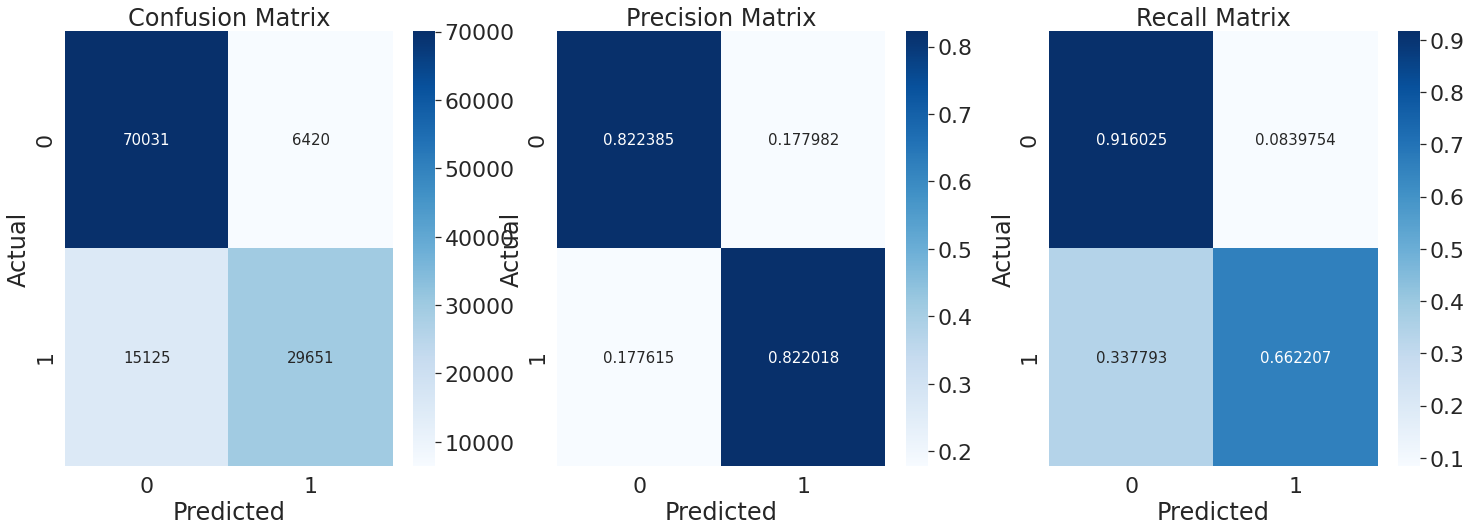

In [32]:
plot_cnf_matrix(y_test,np.round(test_preds))

We observe that the lowest value of log-loss has been observed with LightGBM. The Precision values are also plausible, however, the Recall value for positive class is lower than that of Random Forest. This also comes with slightly higher Recall value for negative class. We could move the threshold a bit to find a good balance.

## Result Summarization

In [46]:
x = PrettyTable()
x.field_names = ['S. No.', 'Model', 'Test Log-loss']
x.add_row([1, 'Random Model', np.round(0.9999421069076613, 4)])
x.add_row([2, 'Logistic Regression', np.round(0.5176614596920359, 4)])
x.add_row([3, 'Linear SVM', np.round(0.5250044409085702, 4)])
x.add_row([4, 'MultinomialNB', np.round(0.4976804453930295, 4)])
x.add_row([5, 'RandomForest', np.round(0.36005836747884595, 4)])
x.add_row([6, 'LightGBM', np.round(0.35839302183094246, 4)])

In [47]:
print(x)

+--------+---------------------+---------------+
| S. No. |        Model        | Test Log-loss |
+--------+---------------------+---------------+
|   1    |     Random Model    |     0.9999    |
|   2    | Logistic Regression |     0.5177    |
|   3    |      Linear SVM     |     0.525     |
|   4    |    MultinomialNB    |     0.4977    |
|   5    |     RandomForest    |     0.3601    |
|   6    |       LightGBM      |     0.3584    |
+--------+---------------------+---------------+
